## Electronic Band Structure
---

In [1]:
import os
#os.environ["ASE_ABINIT_COMMAND"]="mpirun -np 8 abinit  < PREFIX.files > PREFIX.log"
os.environ["ABINIT_PP_PATH"]="/home/jochym/Projects/abinitio-methods/psp:/usr/share/abinit/psp:/usr/share/abinit/psp/HGH"

Crystalline solids have multiple peculiarities connected with their fundamental property: discrete translational symmetry. Additionally, they exhibit additional symmetries which influence their properties (e.g. electronic band structure) as well as procedures used in the calculation. Dealing with crystals require use of Periodic Boundary Conditions and, often, reciprocal space, Brillouin Zone etc. ASE provides multiple tools for working with crystals. We will use some of them in the following examples - which is modeled after one of the AbInit tutorials.

In the following exercise we will:
* build a crystal of Silicon,
* calculate its lattice parameters,
* derive its electronic band structure.

As usual the detailed technical documentation regarding ASE toolbox can be found [ASE documentation site](https://wiki.fysik.dtu.dk/ase/index.html). The documentation concerning the DFT tool used in the exercise is located at [AbInit documentation site](https://docs.abinit.org/).

In [2]:
%pylab inline
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.calculators.abinit import Abinit
import ase.io
from ase import units as un
import os

Populating the interactive namespace from numpy and matplotlib


### Building the Silicon crystal

The silicon has a simple crystal structure with two atoms per primitive unit cell - in fact it is the same structure as diamond. Thus, building the structure is almost trivial - the only free parameter is the length of the lattice vector $a$.

In [3]:
Si = bulk('Si', crystalstructure='diamond', a=5.446 )#a=5.46931040)
print(Si.cell.cellpar())

[ 3.85090353  3.85090353  3.85090353 60.         60.         60.        ]


### Checking the structure

In [4]:
calc = Abinit(label='Si', directory="work_05", v8_legacy_format=True,
              ecut= 350,
              pps='psp8',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[4,4,4],
              nshiftk=4,
              shiftk=[[0.5, 0.5, 0.5],
                      [0.5, 0.0, 0.0],
                      [0.0, 0.5, 0.0],
                      [0.0, 0.0, 0.5]]
              )

Si.set_calculator(calc)
print(Si.get_potential_energy(), Si.get_stress()/un.GPa)

-229.96114264601286 [0.03669724 0.03669724 0.03669724 0.         0.         0.        ]


### Running Self-Consistent DFT

In [5]:
Si.calc.set(prtden=1)
Si.get_potential_energy()

-229.96114264601286

### Calculating band structure from SCF electronic density

In [6]:
scf_res = Si.calc.results

In [7]:
del Si.calc.parameters['toldfe']

In [8]:
Si.calc.set(iscf=-2, getden=-1, nband=8, kptopt=-3, ndivsm=20, nstep=20, tolwfr=1e-10,
            kptbounds=[[1/2,0,0],[0,0,0],[0,1/2,1/2],[1,1,1]])
Si.calc.atoms=Si

In [9]:
!cp work_05/Sio_DEN work_05/Sii_DEN

In [10]:
Si.calc.calculate()

### Plotting the band structure

In [11]:
pth = Si.calc.results['ibz_kpoints']
pth = array([0]+list(norm(pth[1:]-pth[:-1], axis=1))).cumsum()
ev = Si.calc.results['eigenvalues'][0].T
Efermi = ev[3].max()

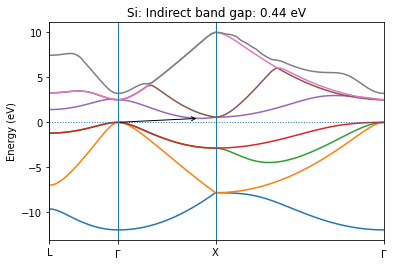

In [12]:
kpnts = [0,20,43,76]
for bnd in ev:
    plot(pth, bnd-Efermi)
axhline(ls=":", lw=1)
for k in pth[array(kpnts)]:
    axvline(k, lw=1)
xticks(pth[array(kpnts)], ['L', '$\Gamma$', 'X', '$\Gamma$']);
title(f'Si: Indirect band gap: {ev[4].min()-ev[2].max():.2f} eV')
xlim(pth[0], pth[-1])
frm = ev[3].argmax()
to = ev[4].argmin()
annotate("", xy=(pth[to], ev[4][to]-Efermi), 
         xytext=(pth[frm], ev[3][frm]-Efermi), 
         arrowprops=dict(arrowstyle="->"))
ylabel('Energy (eV)')
savefig('Si_bs_abinit.pdf')